In this tutorial, we aim to use CNN network to extract features from combustion data.

<font size="5">**Have a look at MRB data**<font>

First, we load important libraries.

In [1]:
import os
import pandas as pd
import keyfi as kf
import numpy as np

2022-10-30 15:30:41.776526: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-30 15:30:41.949130: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-30 15:30:41.953076: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-30 15:30:41.953088: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

Load vtk data of the MRB in this path:

In [2]:
path_input  = '../keyfi/input/2DMRB.vtk'
data, mesh = kf.import_vtk_data(path_input)

<font size="3">Clean data and only keep the temperature T and 17 species, these are also the input to CEMA analyse for comparison:<font>

In [3]:
cleaned_data = kf.clean_data(data, dim=2, vars_to_drop=None, 
vars_to_keep=['T', 'H2', 'H', 'O', 'O2', 'OH', 'H2O', 'HO2', 'CH2', 'CH2S', 'CH3', 'CH4', 'CO', 'CO2', 'HCO', 'CH2O', 'CH2OH', 'N2']
)

In [4]:
print ("data length N = {}\n".format(len(cleaned_data)))
print (cleaned_data.describe())

data length N = 70951

                  T            H2             H             O            O2  \
count  70951.000000  7.095100e+04  7.095100e+04  7.095100e+04  70951.000000   
mean    1201.693848  7.142781e-05  1.151170e-05  1.988698e-04      0.120411   
std      695.951721  1.552306e-04  3.476686e-05  4.076611e-04      0.080185   
min      302.999176  0.000000e+00  0.000000e+00  0.000000e+00      0.014531   
25%      332.883057  2.518204e-08  1.054987e-16  4.439970e-13      0.048136   
50%     1596.588135  1.018075e-05  2.899334e-07  3.018385e-05      0.067881   
75%     1843.843750  6.129315e-05  3.467945e-06  1.645271e-04      0.211072   
max     2078.481934  1.397522e-03  3.398931e-04  2.499236e-03      0.234456   

                 OH           H2O           HO2           CH2          CH2S  \
count  7.095100e+04  70951.000000  7.095100e+04  7.095100e+04  7.095100e+04   
mean   8.057848e-04      0.057214  9.647544e-06  3.450537e-07  2.457472e-08   
std    1.103116e-03      0.0

Import two scalers and we try to scale the data range first using MinMaxScaler (not necessarily)

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [6]:
scaled_data = MinMaxScaler().fit_transform(cleaned_data)
# store the results in a data frame
df_scaled = pd.DataFrame(scaled_data, columns=cleaned_data.columns)
print (df_scaled.describe())

                  T            H2             H             O            O2  \
count  70951.000000  70951.000000  7.095100e+04  7.095100e+04  70951.000000   
mean       0.506256      0.051109  3.386913e-02  7.957149e-02      0.481505   
std        0.391984      0.111077  1.023291e-01  1.631958e-01      0.364578   
min        0.000000      0.000000  0.000000e+00  0.000000e+00      0.000000   
25%        0.016831      0.000018  3.103880e-13  1.776531e-10      0.152803   
50%        0.728584      0.007285  8.530134e-04  1.207723e-02      0.242583   
75%        0.867845      0.043858  1.020305e-02  6.583095e-02      0.893671   
max        1.000000      1.000000  1.000000e+00  1.000000e+00      1.000000   

                 OH           H2O           HO2           CH2          CH2S  \
count  7.095100e+04  70951.000000  70951.000000  7.095100e+04  7.095100e+04   
mean   1.518958e-01      0.500361      0.040885  5.366222e-03  5.617640e-03   
std    2.080350e-01      0.388259      0.117927  3.

In [7]:
print (df_scaled.shape) #equivalent to already flattened

(70951, 18)


Have a look at our data T on mesh

/home/kai/anaconda3/envs/kth/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(f'Failed to use notebook backend: \n\n{e}\n\n'


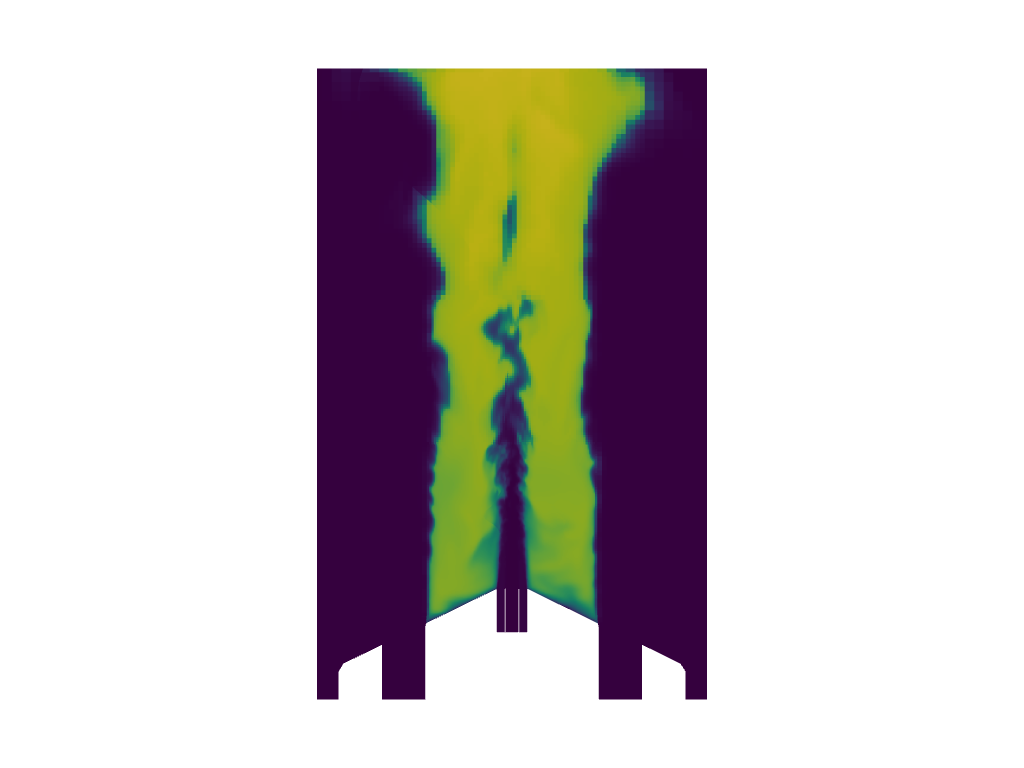

In [8]:
import pyvista as pv
p = pv.Plotter(notebook=True, off_screen=False)
mesh['values'] = df_scaled['T']
p.add_mesh(mesh, scalars='values')
p.remove_scalar_bar()
p.background_color = 'w'
p.camera_position = 'yz'
p.show()


In [9]:
from sklearn.model_selection import train_test_split
"""No need to split at the moment, as we only have 1 snapshot
v_trn, v_val = train_test_split(df_scaled, test_size = 0.2, random_state = 24, shuffle = True) #incomplete
print (v_trn.shape, v_val.shape)
#Let's reshape to get 4D data as input (note  nt =1 ignored), sounds stupid though.
v_trn = np.reshape(v_trn.to_numpy().flatten(), (473, 120, -1))
v_val = np.reshape(v_val.to_numpy().flatten(), (473, 120, -1))
nx, ny, nv  = v_trn.shape
print (nx,ny,nv)
"""
print ()
df_scaled = np.reshape(df_scaled.to_numpy().flatten(), (1, df_scaled.shape[0], -1))
nx, ny, nv  = df_scaled.shape
print (nx,ny,nv)


1 70951 18


Let me try to convolve the data and have a look.

In [12]:
import tensorflow as tf
from keras.utils.vis_utils import plot_model
from tensorflow.keras import layers, models, activations, optimizers, callbacks

In [14]:
yc = layers.Conv2D(1, (3, 3), strides = (1, 1), padding = 'same', dilation_rate = (1, 1))(df_scaled.reshape(1, nx,ny,nv))
yc = yc.numpy()

print(yc.shape)

(1, 1, 70951, 1)


/home/kai/anaconda3/envs/kth/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(f'Failed to use notebook backend: \n\n{e}\n\n'


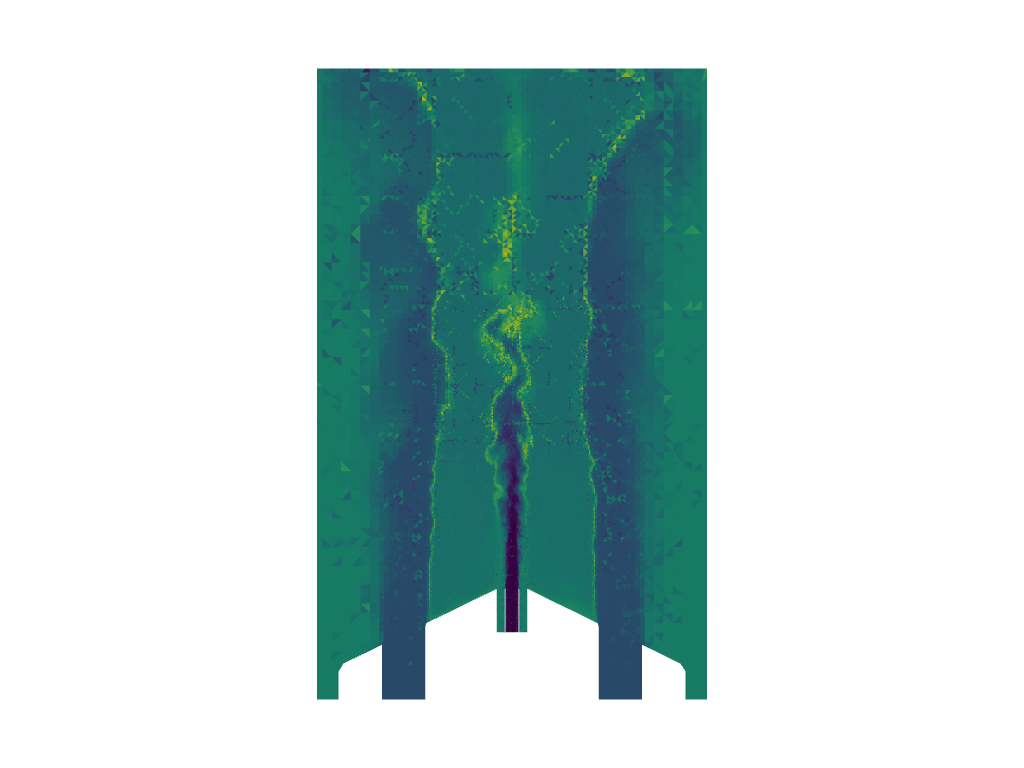

In [17]:
p = pv.Plotter(notebook=True, off_screen=False)
mesh['values'] = yc.flatten()
p.add_mesh(mesh, scalars='values')
p.remove_scalar_bar()
p.background_color = 'w'
p.camera_position = 'yz'
p.show()

Now let's build neural network

2022-10-30 15:30:47.070151: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-30 15:30:47.070234: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-10-30 15:30:47.070284: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-10-30 15:30:47.070332: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2022-10-30 15:30:47.070379: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

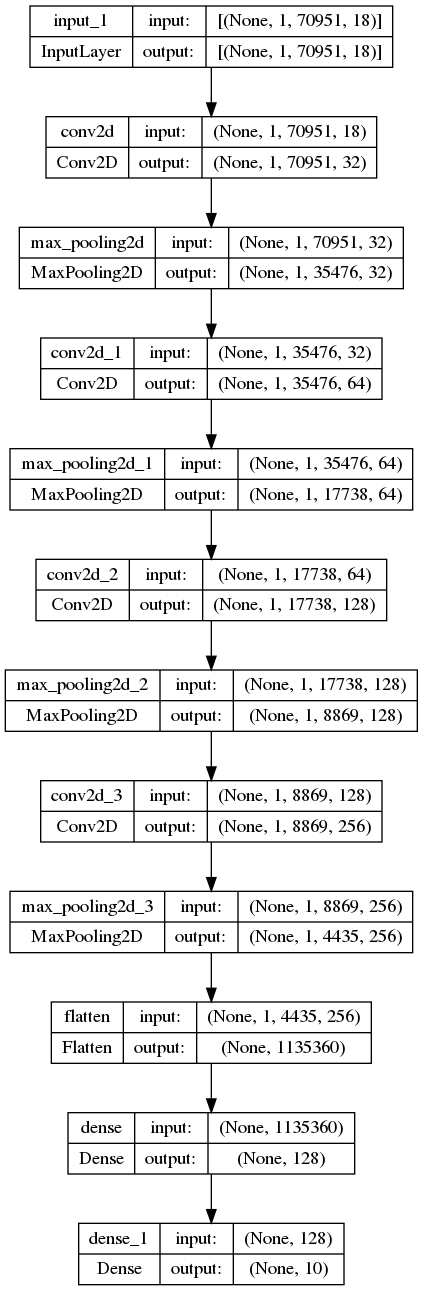

In [11]:
d = 10 #latent space
act = activations.relu #relu activation
fs = (3,3) #kernal size for conv2D
ffs = (2, 2) #kernal size for maxPooling
st = (1, 1) #stride

inp = layers.Input(shape = (nx, ny, nv))
x = layers.Conv2D(32, fs, activation = act, strides = st, padding = 'same')(inp)
x = layers.MaxPooling2D(ffs, padding = 'same')(x)
x = layers.Conv2D(64, fs, activation = act, strides = st, padding = 'same')(x)
x = layers.MaxPooling2D(ffs, padding = 'same')(x)
x = layers.Conv2D(128, fs, activation = act, strides = st, padding = 'same')(x)
x = layers.MaxPooling2D(ffs, padding = 'same')(x)
x = layers.Conv2D(256, fs, activation = act, strides = st, padding = 'same')(x)
x = layers.MaxPooling2D(ffs, padding = 'same')(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation = act)(x)
code = layers.Dense(d)(x)

encoder = models.Model(inp, code, name = 'CNN_encoder')
#print(encoder.summary())
plot_model(encoder, to_file='model_plot.png', show_shapes=True, show_layer_names=True)